In [ ]:
# ============================================================
# DRIVER DROWSINESS DETECTION (HIGH ACCURACY VERSION)
# ============================================================

# ------------------ STEP 1: IMPORT LIBRARIES ------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("rakibuleceruet/drowsiness-prediction-dataset")
print("Dataset path:", path)


100%|██████████| 2.17G/2.17G [01:15<00:00, 30.7MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/rakibuleceruet/drowsiness-prediction-dataset/versions/1


In [ ]:
dataset_dir = dataset_dir = path + "/0 FaceImages"


In [ ]:
# ------------------ STEP 3: IMAGE GENERATORS ------------------
img_size = (160, 160)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.7, 1.3],
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

print("Class indices:", train_gen.class_indices)
class_labels = {v: k for k, v in train_gen.class_indices.items()}

Found 7296 images belonging to 2 classes.
Found 1824 images belonging to 2 classes.
Class indices: {'Active Subjects': 0, 'Fatigue Subjects': 1}


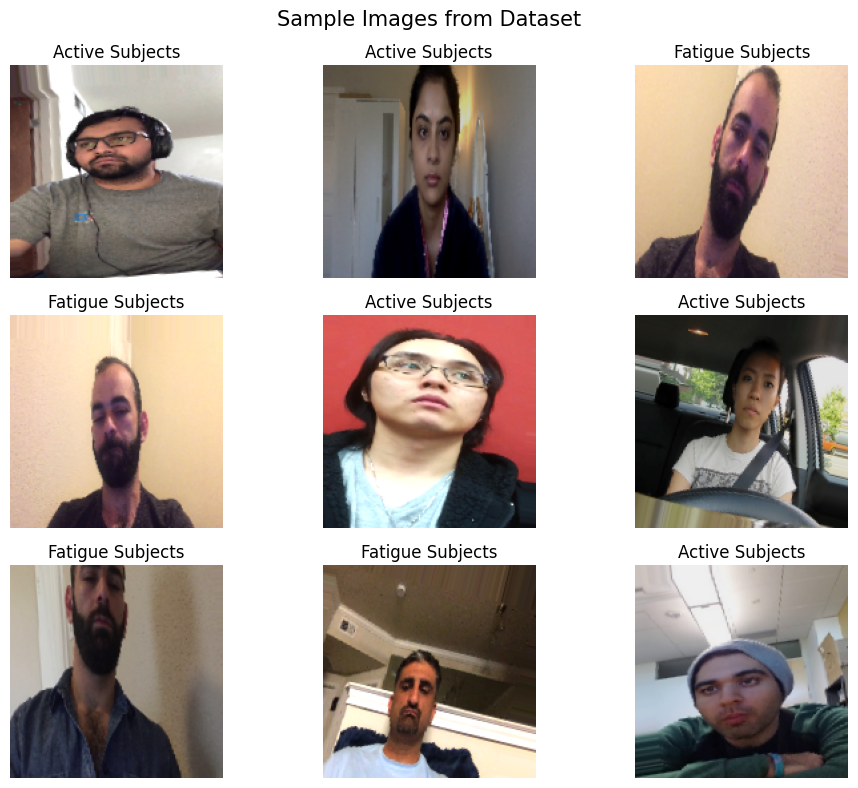

In [ ]:
# ------------------ STEP 4: VISUALIZE SAMPLE IMAGES ------------------
x_batch, y_batch = next(train_gen)
plt.figure(figsize=(10, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    label = int(y_batch[i]) if y_batch.ndim == 1 else int(np.argmax(y_batch[i]))
    plt.title(class_labels[label])
    plt.axis('off')
plt.suptitle("Sample Images from Dataset", fontsize=15)
plt.tight_layout()
plt.show()


In [ ]:
# ------------------ STEP 5: DEFINE MODEL (MobileNetV2) ------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# ------------------ STEP 6: CALLBACKS ------------------
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
]


In [ ]:
# ------------------ STEP 7: CLASS WEIGHTS ------------------
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [ ]:
# ------------------ STEP 8: TRAIN MODEL ------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.6810 - loss: 0.5940 - val_accuracy: 0.7637 - val_loss: 0.5141 - learning_rate: 1.0000e-04
Epoch 2/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.7734 - loss: 0.4418 - val_accuracy: 0.7664 - val_loss: 0.4904 - learning_rate: 1.0000e-04
Epoch 3/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.7876 - loss: 0.4264 - val_accuracy: 0.7522 - val_loss: 0.4901 - learning_rate: 1.0000e-04
Epoch 4/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.8008 - loss: 0.3996 - val_accuracy: 0.7686 - val_loss: 0.4901 - learning_rate: 1.0000e-04
Epoch 5/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.8184 - loss: 0.3822 - val_accuracy: 0.7703 - val_loss: 0.4542 - learning_rate: 1.0000e-04
Epoch 6/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.8065 - loss: 0.3869 - val_accuracy: 0.7791 - val_loss: 0.4355 - learning_rate: 1.0000e-04
Epoch 7/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - acc

In [ ]:
val_gen.reset()
pred = model.predict(val_gen)
predicted_classes = (pred > 0.5).astype("int32").flatten()
true_classes = val_gen.classes

acc = accuracy_score(true_classes, predicted_classes)
prec = precision_score(true_classes, predicted_classes)
rec = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print("\n📊 Evaluation Metrics:")
print(f"Accuracy : {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Recall   : {rec*100:.2f}%")
print(f"F1-Score : {f1*100:.2f}%")

57/57 ━━━━━━━━━━━━━━━━━━━━ 57s 983ms/step

📊 Evaluation Metrics:
Accuracy : 80.54%
Precision: 80.77%
Recall   : 80.15%
F1-Score : 80.46%


In [ ]:
# ------------------ STEP 9: FINE-TUNE ------------------
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 862s 4s/step - accuracy: 0.7351 - loss: 0.5657 - val_accuracy: 0.7966 - val_loss: 0.4544 - learning_rate: 1.0000e-05
Epoch 2/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 865s 4s/step - accuracy: 0.8020 - loss: 0.4028 - val_accuracy: 0.8130 - val_loss: 0.4207 - learning_rate: 1.0000e-05
Epoch 3/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 829s 4s/step - accuracy: 0.8272 - loss: 0.3614 - val_accuracy: 0.8279 - val_loss: 0.3742 - learning_rate: 1.0000e-05
Epoch 4/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 824s 4s/step - accuracy: 0.8488 - loss: 0.3333 - val_accuracy: 0.8087 - val_loss: 0.4010 - learning_rate: 1.0000e-05
Epoch 5/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 852s 4s/step - accuracy: 0.8621 - loss: 0.3076 - val_accuracy: 0.8355 - val_loss: 0.3526 - learning_rate: 1.0000e-05
Epoch 6/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 853s 4s/step - accuracy: 0.8721 - loss: 0.2828 - val_accuracy: 0.8427 - val_loss: 0.3191 - learning_rate: 1.0000e-05
Epoch 7/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 821s 4s/step - acc

In [ ]:
val_gen.reset()
pred = model.predict(val_gen)
predicted_classes = (pred > 0.5).astype("int32").flatten()
true_classes = val_gen.classes

acc = accuracy_score(true_classes, predicted_classes)
prec = precision_score(true_classes, predicted_classes)
rec = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print("\n📊 Evaluation Metrics:")
print(f"Accuracy : {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Recall   : {rec*100:.2f}%")
print(f"F1-Score : {f1*100:.2f}%")

57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step

📊 Evaluation Metrics:
Accuracy : 87.39%
Precision: 88.66%
Recall   : 85.75%
F1-Score : 87.18%


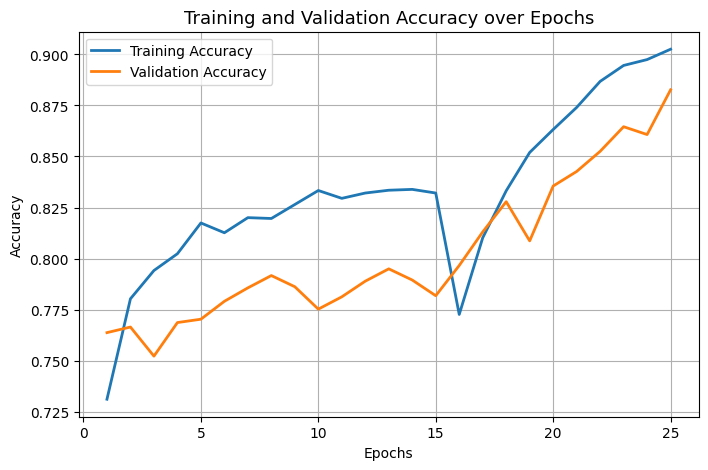

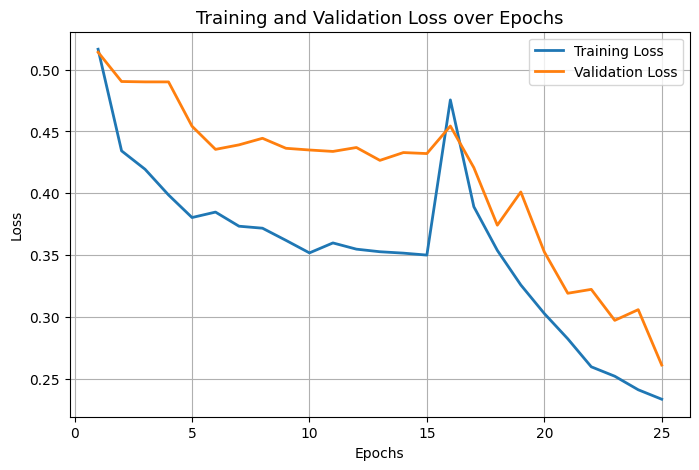

In [ ]:
# ------------------ STEP 9.5: PLOT TRAINING AND VALIDATION CURVES ------------------

# Combine training histories (initial + fine-tuning)
acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plot Accuracy Curve
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy over Epochs', fontsize=13)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, loss, label='Training Loss', linewidth=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss over Epochs', fontsize=13)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


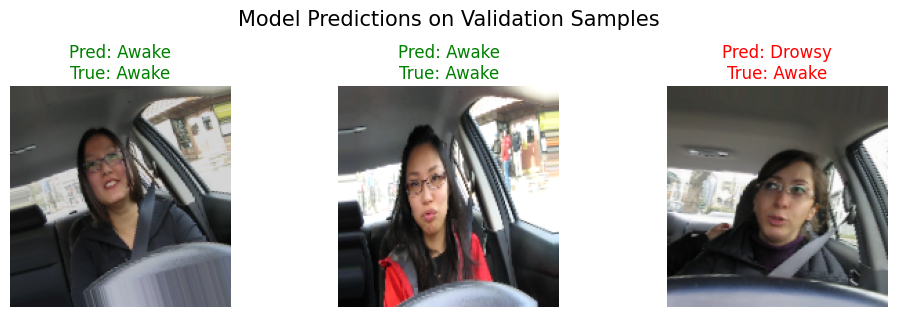

In [ ]:
# ------------------ STEP 13: VISUALIZE MODEL PREDICTIONS ------------------

x_batch, y_batch = next(val_gen)
predictions = model.predict(x_batch)
plt.figure(figsize=(10, 8))

for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    pred_label = "Drowsy" if predictions[i] < 0.5 else "Awake"
    true_label = "Drowsy" if y_batch[i] == 1 else "Awake"
    color = "green" if pred_label == true_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis('off')

plt.suptitle("Model Predictions on Validation Samples", fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
# ------------------ STEP 10: EVALUATION ------------------
val_gen.reset()
pred = model.predict(val_gen)
predicted_classes = (pred > 0.5).astype("int32").flatten()
true_classes = val_gen.classes

acc = accuracy_score(true_classes, predicted_classes)
prec = precision_score(true_classes, predicted_classes)
rec = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print("\n📊 Evaluation Metrics:")
print(f"Accuracy : {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Recall   : {rec*100:.2f}%")
print(f"F1-Score : {f1*100:.2f}%")

57/57 ━━━━━━━━━━━━━━━━━━━━ 56s 972ms/step

📊 Evaluation Metrics:
Accuracy : 87.77%
Precision: 88.75%
Recall   : 86.51%
F1-Score : 87.62%


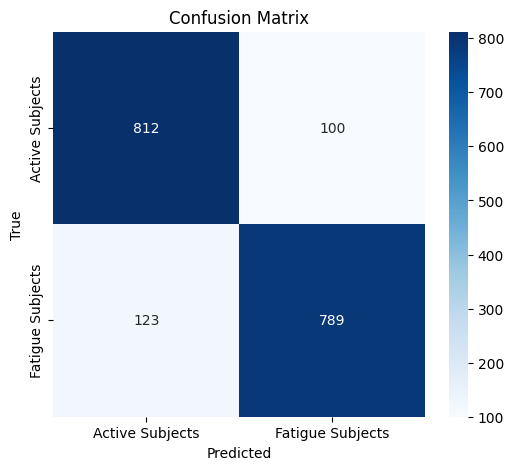


Detailed Classification Report:

                  precision    recall  f1-score   support

 Active Subjects       0.87      0.89      0.88       912
Fatigue Subjects       0.89      0.87      0.88       912

        accuracy                           0.88      1824
       macro avg       0.88      0.88      0.88      1824
    weighted avg       0.88      0.88      0.88      1824



In [ ]:
# ------------------ STEP 11: CONFUSION MATRIX ------------------
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[class_labels[0], class_labels[1]],
            yticklabels=[class_labels[0], class_labels[1]])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nDetailed Classification Report:\n")
print(classification_report(true_classes, predicted_classes,
                            target_names=[class_labels[0], class_labels[1]]))

/tmp/ipython-input-3306349340.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')


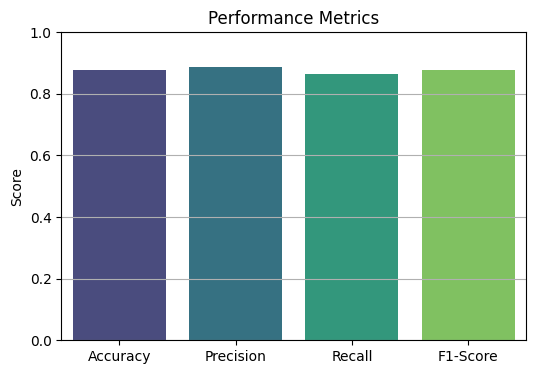

In [ ]:
# ------------------ STEP 12: METRICS BAR CHART ------------------
metrics = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1}
plt.figure(figsize=(6,4))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')
plt.title("Performance Metrics")
plt.ylim(0,1)
plt.ylabel("Score")
plt.grid(axis='y')
plt.show()

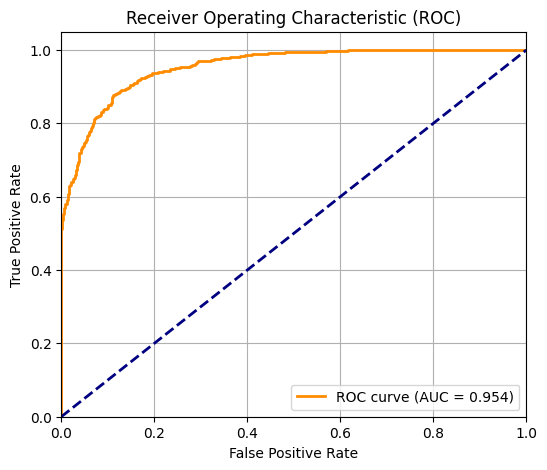

In [ ]:
# ------------------ STEP 13: ROC CURVE ------------------
fpr, tpr, _ = roc_curve(true_classes, pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()